# 분류 분석

## 목차
1. 타이타닉 생존자 가려내기   
    1.1 탐색: 타이타닉 데이터 살펴보기  
    1.2 분류: 생존자 분류 모델 만들기  
    1.3 모델 개선: 피처 엔지니어링  
    1.4 평가: 모델 검증하기

2. 강남역 맛집 리뷰로 알아보는 감성 분류   
    2.1 크롤링: 카카오맵 리뷰 크롤링  
    2.2 텍스트 전처리: 분류 모델 피처로 변환하기  
    2.3 분류: 긍정/부정 리뷰 분류하기  
    2.4 분석: 중요 키워드 분석하기  

## 1. 타이타닉 생존자 가려내기

타이타닉 승객을 생존자 그룹과 비생존자 그룹으로 분류해보자.  

### 1.1 탐색: 타이타닉 데이터 살펴보기

**타이타닉 데이터셋 구성**
- pclass: Passenger Class, 승객 등급 (1st-Upper, 2nd-Middle, 3rd-Lower)
- survived: 생존 여부 (생존-1, 비생존-0)
- name: 승객 이름
- sex: 승객 성별
- age: 승객 나이
- sibsp: 동승한 형제/배우자 수
- parch: 동승한 부모/자녀 수
- ticket: 티켓 번호
- fare: 승객 지불 요금
- cabin: 선실 이름
- embarked: 승선항(C-쉘 부르크, Q-퀸즈타운, S-사우스 햄튼)
- body: 비생존자 확인 번호
- home.dest: 고향/목적지

**타이타닉 데이터셋 기본 정보**

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_file_path = 'Desktop/python-data-analysis-master/data/titanic_train.csv'
test_file_path = 'Desktop/python-data-analysis-master/data/titanic_test.csv'

df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

df_train.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [4]:
print(df_train.info())
print('--------------------------------------------------')
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     -------------- 

학습 데이터셋에서는 age, cabin, body, home.dest  
테스트 데이터셋에서는 cabin, body, home.dest 피처에 결측치가 존재하는 것을 알 수 있다.  

다음으로 분석에 활용할 수 없는 피처(name, cabin)와 큰 의미가 없는 피처(ticket, body, home.dest)를 제거하자.  

**불필요한 피처 제거**

In [73]:
# 데이터 셋에서 name, ticket, cabin, body, home.dest 피처를 제거
df_train.drop(['name', 'ticket', 'cabin', 'body', 'home.dest'], axis=1, inplace=True)
df_test.drop(['name', 'ticket', 'cabin', 'body', 'home.dest'], axis=1, inplace=True)

**탐색적 데이터 분석**  

각 피처가 분류 분석에 미칠 영향에 대해 알아보자.  
가장 좋은 방법은 데이터를 그룹(생존자/비생존자)으로 나누어 **피처의 그룹 간 차이를 탐색**하는 것이다.  

생존자-1, 비생존자-0 인원수
0    563
1    353
Name: survived, dtype: int64


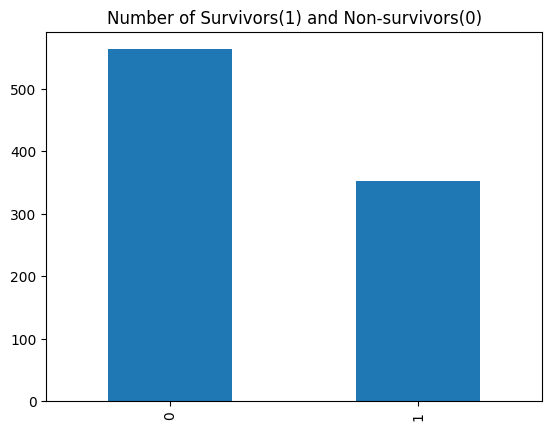

In [20]:
# 생존자와 비생존자 인원수 비교
print('생존자-1, 비생존자-0 인원수')
print(df_train['survived'].value_counts())

df_train['survived'].value_counts().plot.bar()
plt.title('Number of Survivors(1) and Non-survivors(0)')
plt.show()

**pclass, sex, embared 피처의 그룹별 생존자 분포**

승객 등급별 인원수
3    498
1    230
2    188
Name: pclass, dtype: int64


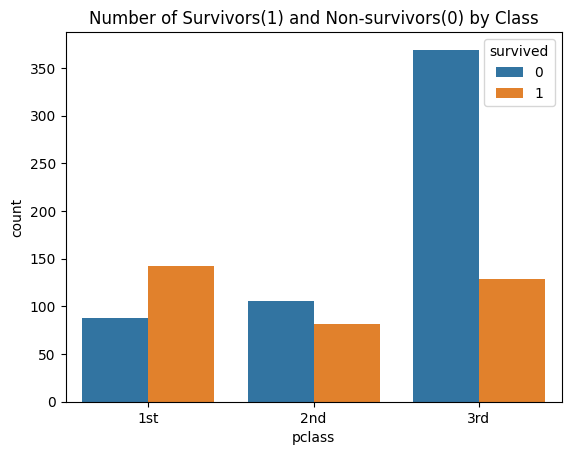

In [35]:
# 생존 여부인 survived 피처를 그룹으로 한 pclass 피처의 그룹별 분포
print('승객 등급별 인원수')
print(df_train['pclass'].value_counts())

ax = sns.countplot(x='pclass', hue='survived', data=df_train)
plt.xticks(np.arange(0,3), labels=['1st', '2nd', '3rd'])
plt.title('Number of Survivors(1) and Non-survivors(0) by Class')
plt.show()

상급 클래스로 갈 수록 생존자의 비율이 늘어나는 것을 알 수 있다.  

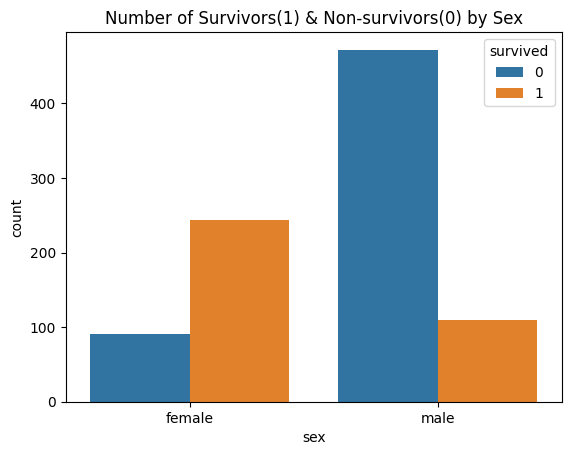

In [57]:
# 생존 여부인 survived 피처를 그룹으로 한 sex 피처의 그룹별 분포
ax = sns.countplot(x='sex', hue='survived', data=df_train)
plt.title('Number of Survivors(1) & Non-survivors(0) by Sex')
plt.show()

남성보다 여성이 더 높은 생존자 비율을 보인다.  

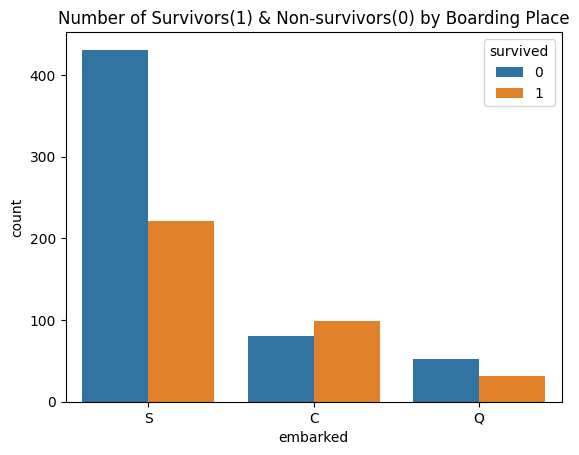

In [56]:
# 생존 여부인 survived 피처를 그룹으로 한 embarked 피처의 그룹별 분포
ax = sns.countplot(x='embarked', hue='survived', data=df_train)
plt.title('Number of Survivors(1) & Non-survivors(0) by Boarding Place')
plt.show()

S-사우스 햄튼, C-쉘 부르크, Q-퀸즈 타운  

유독 사우스 햄튼에서 승선한 승객의 생존자 비율이 낮다. (비생존자 비율의 절반 정도)

피처별 생존자와 비생존자의 분포를 살펴본 결과,  
pclass, sex > embarked 순으로 피처의 그룹별 생존자 분포 차이가 크고  
차이가 클수록 생존자 분류에 영향을 미칠 수 있다고 생각해 볼 수 있다.  

**수치형 피처 탐색**

수치헝 피처들을 탐색할 수 있는 자동화 함수 valid_features()를 생성해보자.  

함수가 실행하는 내용
- 두 그룹(생존자, 비생존자) 간의 분포를 비교하는 그래프 출력
- 두 그룹 각각의 표준편차 출력
- 두 그룹 간의 T-test 검정 실시하여 출력
    - T-test 검정: 검정통계량이 귀무가설 하에서 t-분포를 따르는 통계적 가설 검정법
- 두 그룹 각각에 Shapiro-wilk 검정을 실시하여 출력
    - Shapiro-wilk 검정: 주어진 데이터가 얼마나 정규성을 따르는지, 즉 얼마나 정규분포에 가까운지를 측정

In [48]:
from scipy import stats

# 두 집단의 피처를 비교해주며 탐색작업을 자동화하는 함수 정의
def valid_features(df, col_name, distribution_check=True):
    
    # 두 집단 (survived=1, not survived=0)의 분포 그래프 출력
    g = sns.FacetGrid(df, col='survived') # FacetGrid: 범주형 데이터 시각화에 좋은 방법 
    g.map(plt.hist, col_name, bins=30)
    
    # 두 집단의 표준편차 출력
    titanic_survived = df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    std = np.std(titanic_survived_static)
    print('data std is', '%.2f' % std)

    titanic_n_survived = df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    std = np.std(titanic_n_survived_static)
    print('data std is', '%.2f' % std)
    
    # T-test로 두 집단의 평균 차이 검정
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name],
                                        equal_var=False)
        # stats.ttest_ind(): Calculate the T-test for the means of two independent samples
    print('The t-statistic and p-value assuming equal variances is %.3f and %.3f.' % tTestResult)
    print('The t-statistic and p-value not assuming equal variances is %.3f and %.3f.' % tTestResult)

    if distribution_check:
        # Shapiro-Wilk 검정: 분포의 정규성 정도를 검증합니다. 
        shapiro_survived = stats.shapiro(titanic_survived[col_name]) 
        print('The w-statistic and p-value in Survived %.3f and %.3f' % shapiro_survived)
        shapiro_n_survived = stats.shapiro(titanic_n_survived[col_name])
        print('The w-statistic and p-value in Not Survived %.3f and %.3f' % shapiro_n_survived)

**t-statistic(t-value)**  
: 두 집단의 평균의 차이를 나타내는 정도  
- t-value가 0에서 멀다 - 평균 차이가 크다 (음수인지 양수인지는 귀무가설에 따라, 순서에 따라 바뀐다.)
- t-value가 0에 가깝다 - 평균 차이가 없다


t-value는 비교할 때마다 값이 달라질 수 있다.  
이때 p-value를 통해 이러한 t-value의 유의성을 판단할 수 있다. (우연일까? 아닐까?에 대한 판단)


**p-value**   
: 어떤 사건이 우연히 발생할 확률  
: 확률분포 그래프에서 양쪽 극단값의 범위를 설정하여 통계적으로 나오는 결과의 신뢰성
- p-value가 작다 - 우연일 가능성이 작다 -> 인과관계가 있을 것이다고 추론
- 통계적 유의 수준: 0.05 (5%) 이하  
- p-value가 0.05보다 크다 - 우연히 발생한 사건이라고 판단, 인과관계가 없을 것이라고 추론

두 집단의 차이가 있다는 주장에서  
p-value가 0.05 이하면 95%로 통계를 신뢰할 수 있다고 판단하여 두 집단 간의 유의미한 차이가 있다고 해석 할 수 있고,  
p-value가 0.05 이상이면 통계를 신뢰할 수 없다고 판단하고 유의미한 차이가 있지 않다(인과관계가 없다)고 해석할 수 있다.  
즉, p-value가 작아질수록 가정하는 주장에 대한 신뢰도가 올라가게 된다.

**age, sibsp, parch, fare 피처에서 생존자와 비생존자 간의 평균 차이**

data std is 14.22
data std is 13.71
The t-statistic and p-value assuming equal variances is -0.546 and 0.585.
The t-statistic and p-value not assuming equal variances is -0.546 and 0.585.
The w-statistic and p-value in Survived 0.982 and 0.001
The w-statistic and p-value in Not Survived 0.968 and 0.000


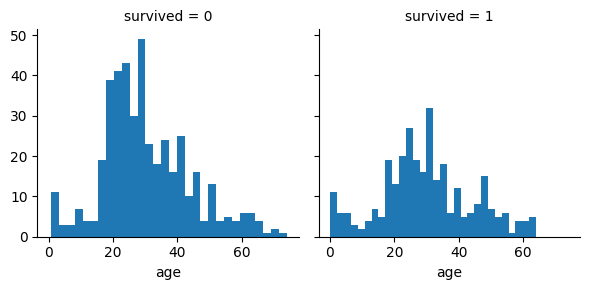

In [50]:
## 자동화 함수 실행
# age 피처 탐색
valid_features(df_train[df_train['age']>0], 'age', distribution_check=True)

분석 결과, age 피처에서 두 그룹(생존자&비생존자) 간의 평균 차이가 크지 않지만 (t-statistic: -0.546)  
우연일 가능성(p-value: 0.585)도 높다.   

data std is 0.64
data std is 1.34
The t-statistic and p-value assuming equal variances is -2.118 and 0.034.
The t-statistic and p-value not assuming equal variances is -2.118 and 0.034.


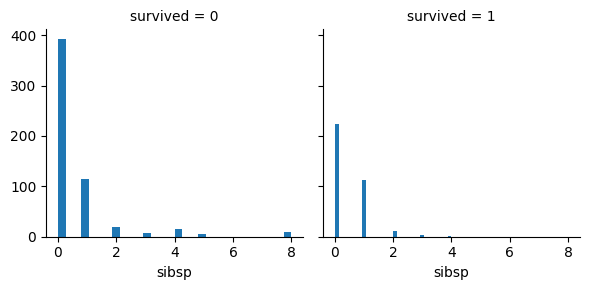

In [62]:
# sibsp 피처 탐색
valid_features(df_train, 'sibsp', distribution_check=False)

반면 sibsp 피처에서는 두 그룹 간의 평균 차이가 어느 정도 존재하고 우연일 가능성도 낮은 것을 알 수 있다.

data std is 0.74
data std is 0.89
The t-statistic and p-value assuming equal variances is 1.865 and 0.063.
The t-statistic and p-value not assuming equal variances is 1.865 and 0.063.


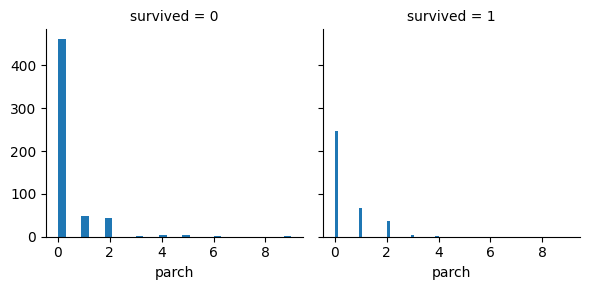

In [58]:
# parch 피처 탐색
valid_features(df_train, 'parch', distribution_check=False)

parch 피처에서는 두 집단의 평균의 차이가 있지만 우연일 가능성도 있다.

data std is 60.68
data std is 33.65
The t-statistic and p-value assuming equal variances is 7.523 and 0.000.
The t-statistic and p-value not assuming equal variances is 7.523 and 0.000.


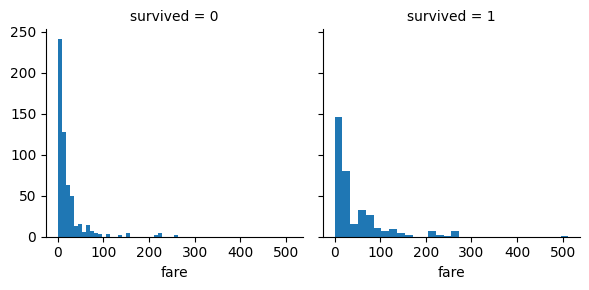

In [59]:
# fare 피처 탐색
valid_features(df_train, 'fare', distribution_check=False)

fare 피처는 두 집단의 평균의 차이가 비교적 큰 편이고 우연일 가능성도 낮으므로  
두 집단의 분류(생존자 분류)에 미치는 영향력이 있을 것이라고 볼 수 있다.   

피처를 생존자와 비생존자로 나누고 각 평균을 비교해본 결과,  
fare >> sibsp > parch >> age 순서대로 생존자 분류에 영향을 미칠 수 있다고 생각해 볼 수 있다.   

### 1.2 분류: 생존자 분류 모델 만들기

이제 분류 모델을 만들어보자.  

첫 번째 방법은 **로지스틱 회귀 모델(Logistic Regression)** 을 이용한 분류이다.  

로지스틱 회귀 모델은 **기존 회귀 분석 예측값 Y를 0~1 사이의 값으로 제한하여  
0.5 보다 크면 1, 0.5 보다 작으면 0이라고 분류하는 방법**이다.  

일반적인 회귀 모델과 마찬가지로 **계수 분석을 통한 피처의 영향력 해석이 용이**하다는 장점이 있다.  

로지스틱 모델을 사용하기 위해 데이터를 가공한다.  
먼저 결측값을 처리해보자. 크게 두 가지 방법이 있다.  
1. 결측이 존재하는 데이터 삭제
2. 평균값/중앙값/최빈값 등 임이의 수치로 대체

1번 방법은 처리가 쉽고 분석에서의 주관이 개입될 여지가 없다는 장점이 있다. 하지만 중요한 정보를 삭제하게 될 위험도 있다.  

2번 방법은 데이터를 모두 분석에 활용할 수 있다는 장점이 있지만, 수치 왜곡의 가능성이 있다는 단점이 있다.  


**분류 모델을 위해 전처리**

In [64]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    916 non-null    int64  
 1   survived  916 non-null    int64  
 2   sex       916 non-null    object 
 3   age       741 non-null    float64
 4   sibsp     916 non-null    int64  
 5   parch     916 non-null    int64  
 6   fare      916 non-null    float64
 7   embarked  914 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 57.4+ KB


**결측치 처리**  

현재 age, embarked 피처에 결측치가 존재한다. 2번 방법으로 결측값을 임의의 값으로 보정해보자.  


In [74]:
# age 피처의 결측값을 평균값으로 대체
age_mean = df_train[df_train['age']>0]['age'].mean()
df_train['age'] = df_train['age'].fillna(age_mean)
df_test['age'] = df_test['age'].fillna(age_mean) # 이건 data leakage가 아닌가?

# embark 피처의 결측값 2개를 최빈값으로 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

**범주형 변수 처리**

그 다음 원-핫 인코딩 방법으로 범주형 변수를 변환하자.  

현재 데이터셋은 train과 test 데이터로 분리되어 있기 때문에  
원-핫 인코딩을 적용하기 위해 데이터를 하나로 합쳐준다.  << data leakaga issue?? no?  
그리고 인코딩 적용 후 다시 train과 test로 나눈다.  

원-핫 인코딩이 적용되는 피처: sex, embarked

In [75]:
# 원-핫 인코딩을 위한 통합 데이터 프레임(whole_df) 생성
whole_df = pd.concat([df_train, df_test]) # axis=0 (default)

# pandas 패키지를 이용한 원-핫 인코딩 수행
whole_df_encoded = pd.get_dummies(whole_df)

# 다시 이전과 동일하게 나누기 위해 whole_df에서 train, test 데이터가 합쳐지는 위치의 인덱스를 저장 
train_idx_num = len(df_train)

# 인코딩을 수행한 whole_df를 다시 train과 test로 나누기
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]  

df_train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


**로지스틱 회귀 모델 학습**

In [93]:
from sklearn.linear_model import LogisticRegression

# train, test 데이터를 x, y로 분리 (x: y를 제외한 모든 값, y: 분류 예측값(0 or 1) (array 형태))
x_train = df_train.drop(['survived'], axis=1).values
y_train = df_train['survived'].values

x_test = df_test.drop(['survived'], axis=1).values
y_test = df_test['survived'].values

# 로지스틱 회귀 모델 학습
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(x_train, y_train)

# 학습한 모델의 테스트 데이터셋에 대한 예측 결과 반환
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1] # 각 클래스가 1일 확률

**모델 성능 평가 지표**

일반적으로 분류 모델의 평가 기준으로 **Confusion Matrix**를 활용한다.  

 
True Positive (TP)  | False Negative (FN)  
False Positive (FP) | True Negative (TN)

이 정보들을 이용한 **분류 평가 지표**
- **정확도(Accuracy)**: (TP+TN) / (TP+TN+FP+FN)  
- **정밀도(Precision)**: TP / (TP+FP)
- **재현도(Recall)**: TP / (TP+FN)
- **특이도(Specificity)**: TN / (TN+FP)

그리고 이 지표들을 응용한 두 가지 평가 지표
- **F1-score**: 정밀도(Precision)과 재현도(Recall)의 조화 평균값
- **ROC Curve**: 재현도(민감도)와 특이도를 고려하여 종합적인 모델의 성능을 그래프로 나타내는 것
    - 이때 그래프의 넓이를 계산한 **AUC(Area Under Curve)** 를 성능의 지표로 사용한다. 이 값이 **1에 가까울수록** 좋은 분류 모델이다.

**로지스틱 회귀 모델 평가**

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 테스트 데이터셋에 대한 정확도, 정밀도, 재현도, f1-score 출력
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.3f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

accuracy: 0.80
precision: 0.756
recall: 0.67
F1: 0.71


In [105]:
from sklearn.metrics import confusion_matrix

# confusion matrix 출력
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


**AUC**는 분류 결과(y_pred)를 사용하는 것이 아니라, 분류 직전의 **확률값(y_pred_probability)** 인 0~1 사이의 값을 사용한다.   

**threshold(임계값)**: 0 또는 1로 분류하는 기준 값  
예를들어, 임계값이 0.7인 경우에 1일 확률이 0.6이라면 0으로 분류 된다.  
임계값으로 0.5를 생각하기 쉽지만 상황에 따라 기준은 달라진다.  


AUC: 0.838


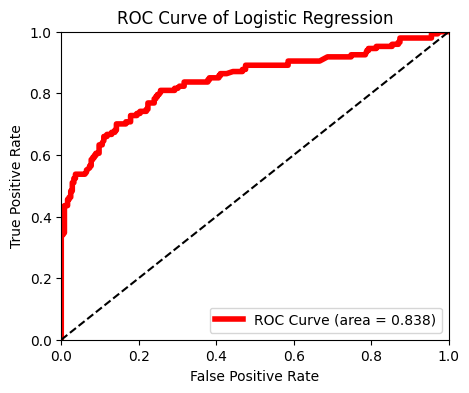

In [111]:
from sklearn.metrics import roc_curve, roc_auc_score

# 로지스틱 회귀 모델의 AUC 출력
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
auc_score = roc_auc_score(y_test, y_pred_probability)
print('AUC: %.3f' % auc_score)

# ROC Curve 그래프 출력
plt.figure(figsize=(5,4))
plt.plot(false_positive_rate, true_positive_rate, 
         label='ROC Curve (area = %0.3f)' % auc_score, 
         color='red', 
         linewidth=4.0)
plt.plot([0,1], [0,1], 'k--') # plt.plot([x_start, x_end], [y_start, y_end], 점선)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.legend(loc='lower right')
plt.show()

이 모델의 AUC 약 0.837로, 생존자를 잘 분류해내는 모델이라고 평가할 수 있다.  

다음으로, 두 번째 분류 방법은 **의사결정 나무(Decision Tree) 모델**을 적용한다.  
로지스틱 회귀 모델과 더불어 가장 대표적인 방법이다.  

의사결정 나무 모델은 **피처 단위로 조건을 분기하여 정답의 집합을 좁혀나가는 방법**이다.  
스무고개 놀이에서 정답을 찾아 나가는 과정과 유사하며, 이를 도식화 하면 생김새가 '나무 모양'과 같다 하여 붙여진 이름이다.  

예시) 타이타닉 탑승객의 생존 여부를 나타내는 결정 트리

male 인가?
- 예
    - age > 9.5 인가?
        - 예
            - 생존 (0.17, 61%)
        - 아니오
            - sibsp > 2.5 인가?
                - 예
                    - 사망 (0.05, 2%)
                - 아니오
                    - 생존 (0.89, 2%)
            
- 아니오
    - 생존 (0.73, 36%)
    
잎(사망/생존) 아래의 숫자는 각각 생존 확률과 탑승객이 그 앞에 해당될 확률을 의미한다.  

**의사결정 나무 모델 학습 및 평가**

Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1: 0.75
AUC: 0.744


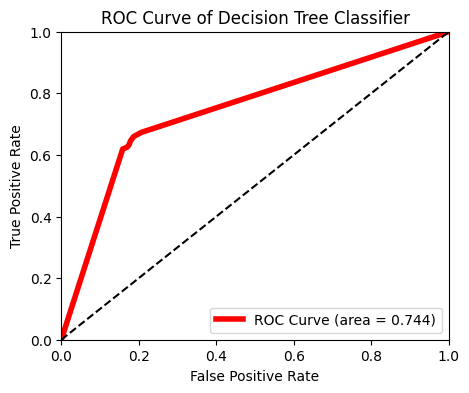

In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

# 의사결정 나무를 학습하고, 학습한 모델로 테스트 데이터셋에 대한 예측값 반환
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train) # 학습
y_pred = dtc.predict(x_test) # 예측
y_pred_probability = dtc.predict_proba(x_test)[:, 1] # 클래스가 1로 예측될 확률

# 학습한 모델의 성능 (평가 지표) 출력 
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Precision: %.2f' % accuracy_score(y_test, y_pred))
print('Recall: %.2f' % accuracy_score(y_test, y_pred))
print('F1: %.2f' % accuracy_score(y_test, y_pred))

# 학습한 모델의 AUC 출력
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
auc_score = roc_auc_score(y_test, y_pred_probability)
print('AUC: %.3f' % auc_score)

# ROC Curve 그래프 출력
plt.figure(figsize=(5,4))
plt.plot(false_positive_rate, true_positive_rate, 
         label='ROC Curve (area = %.3f)' % auc_score,
         color='Red',
         linewidth=4.0)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()

두개의 모델을 학습해본 결과,  
현재 데이터셋에서는 의사결정 나무 모델이 로지스틱 회귀 모델에 비해 모든 평가 지표가 낮은 것을 확인할 수 있다.

### 1.3 모델 개선: 피처 엔지니어링

분류 모델의 성능을 더욱 끌어올리는 방법
- 더 좋은 분류 기법 사용하기
- 더 많은 데이터를 사용하기  

하지만 이 방법들은 쉽게 적용할 수 있는 것들이 아니다.  

이럴 때 **피처 엔지니어링(Feature Engineering)** 을 사용해볼 수 있다.  
피처 엔지니어링이란 모델에 사용할 **피처를 가공하는 분석 작업**을 의미한다.  

이를 수행하기 위해 분석 과정을 처음부터 다시 시작해보자.  

우선 이전과 동일하게 전처리를 한다.    

**전처리**

In [141]:
## 전처리 ##
# 데이터 다시 불러오기
train_file_path = 'Desktop/python-data-analysis-master/data/titanic_train.csv'
test_file_path = 'Desktop/python-data-analysis-master/data/titanic_test.csv'

df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# 불필요한 피처 제거
df_train = df_train.drop(['ticket', 'body', 'home.dest'], axis=1)
df_test = df_test.drop(['ticket', 'body', 'home.dest'], axis=1)

# age의 결측값을 평균값으로 대체
age_mean = df_train[df_train['age']>0]['age'].mean()
df_train['age'] = df_train['age'].fillna(age_mean)
df_test['age'] = df_test['age'].fillna(age_mean)

# embarked의 결측값(2개)을 최빈값으로 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩을 위한 통합 데이터 프레임(whole_df) 생성
whole_df = pd.concat([df_train, df_test])

In [144]:
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 392
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   name      1309 non-null   object 
 3   sex       1309 non-null   object 
 4   age       1309 non-null   float64
 5   sibsp     1309 non-null   int64  
 6   parch     1309 non-null   int64  
 7   fare      1309 non-null   float64
 8   cabin     295 non-null    object 
 9   embarked  1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 112.5+ KB


이제 cabin과 name 피처에 피처 엔지니어링을 적용해보자.  

**피처 엔지니어링 - cabin 피처**

In [142]:
print(whole_df['cabin'].value_counts()[:10])

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F4                 4
B96 B98            4
F33                4
C78                4
D                  4
F2                 4
C22 C26            4
Name: cabin, dtype: int64


cabin 피처는 선실의 정보를 나타내는 데이터로, 선실을 대표하는 알파벳이 반드시 첫 글자에 등장하는 패턴을 가지고 있다. 

이 피처의 결측 데이터는 임의의 'n'으로 채워준다.  
(선실을 구분하는 알파벳이 대문자이므로 구분하기 쉽게 소문자를 사용했다.)

In [146]:
# 결측치를 'n'으로 대체
whole_df['cabin'] = whole_df['cabin'].fillna('n')

그리고 분석에 필요한 첫 알파벳만 추출하여 알파벳별 선실 수를 살펴보자.  

In [147]:
# cabin 피처의 첫 번째 알파벳 추출
whole_df['cabin'] = whole_df['cabin'].apply(lambda x: x[0])

# 알파벳별 선실 수
whole_df['cabin'].value_counts()

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin, dtype: int64

선실 타입 중, G(5)와 T(1) 타입의 수가 너무 적기 때문에 아웃라이어로 가정하고 결측치와 마찬가지로 'na'로 대체한다.  

In [149]:
# 아웃라이어(G, T) 또한 'na'로 대체
whole_df['cabin'] = whole_df['cabin'].replace({'G':'n', 'T': 'n'})

피처 엔지니어링이 끝난 cabin 피처의 생존자/비생존자 그룹 간 분포는 아래와 같다.  

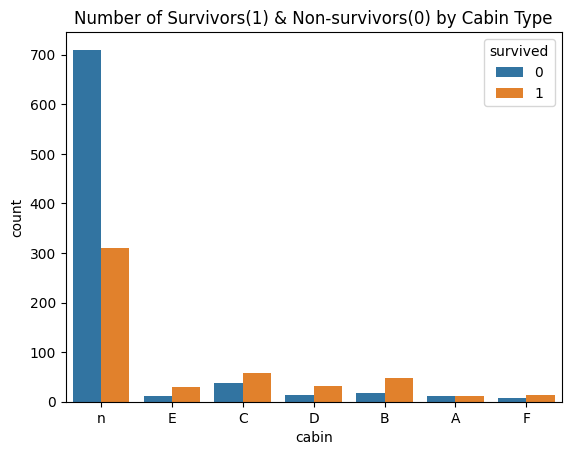

In [179]:
ax = sns.countplot(x='cabin', hue='survived', data=whole_df)
plt.title('Number of Survivors(1) & Non-survivors(0) by Cabin Type')
plt.show()

이를 살펴본 결과, 생존자와 비생존자 두 그룹 간의 유의미한 차이가 있는 것으로 보인다.  
따라서 이 피처를 분류 모델에 사용해볼 수 있다.  

다음으로 name 피처를 살펴보자.  

**피처 엔지니어링 - name 피처**

In [155]:
whole_df['name'].head(10)

0    Mellinger, Miss. Madeleine Violet
1                    Wells, Miss. Joan
2       Duran y More, Miss. Florentina
3                   Scanlan, Mr. James
4         Bradley, Miss. Bridget Delia
5                 Linehan, Mr. Michael
6       Francatelli, Miss. Laura Mabel
7             Quick, Miss. Phyllis May
8             Thayer, Mr. John Borland
9     Silverthorne, Mr. Spencer Victor
Name: name, dtype: object

이름을 살펴보면, (성, 호칭(prefix), 이름)으로 구성되어 있다.  

당시 시대는 사회적 계급이 존재하였기 때문에 호칭 정보는 중요한 데이터로 활용될 수 있다.

호칭을 추출해보자.

In [173]:
# 이름에서 호칭 추출
prefix = whole_df['name'].apply(lambda x: x.split(', ', 1)[1].split('.')[0]) # .split(seperator, maxsplit)
prefix = prefix.unique().tolist()
print(prefix)

['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms', 'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Don', 'Capt']


추출한 호칭을 사회적 지위로 정의하여 범주형 데이터로 변환해 보자. 

In [175]:
# 호칭에 따라 사회적 지위(1910년대 기준)를 정의
status_dict = {
    'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직
    'B': ['Jonkheer', 'the Countess'], # 귀족, 작위
    'C': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성
    'D': ['Mr', 'Don'], # 남성
    'E': ['Miss', 'Mlle', 'Lady'], # 젊은 여성
    'F': ['Master'] # 젊은 남성   
}

# 정의한 호칭의 기준에 따라 A~F의 문자로 name 피처를 다시 정의하는 함수 생성
def give_status(x):
    prefix = x.split(', ', 1)[1].split('.')[0]
    for key, value in status_dict.items():
        for status in value:
            if prefix == status:
                return key
    return 'G'

# 함수 적용하여 name 피처 새롭게 정의
whole_df['name'] = whole_df['name'].apply(lambda x: give_status(x))
print(whole_df['name'].value_counts())

D    758
E    263
C    201
F     61
A     24
B      2
Name: name, dtype: int64


피처 엔지니어링이 끝난 name 피처의 생존자/비생존자 그룹 간 분포는 아래와 같다.  

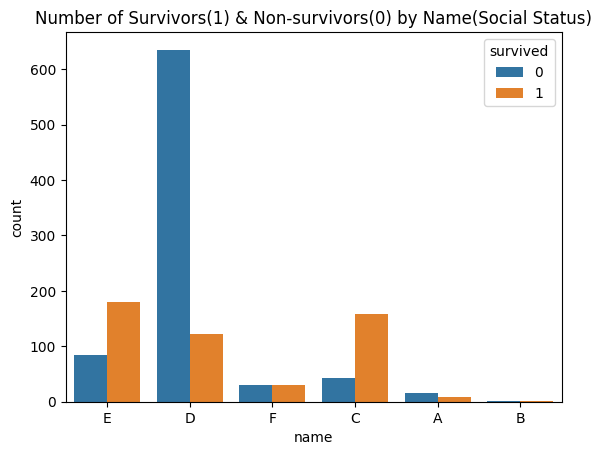

In [178]:
ax = sns.countplot(x='name', hue='survived', data=whole_df)
plt.title('Number of Survivors(1) & Non-survivors(0) by Name(Social Status)')
plt.show()

마찬가지로, 새롭게 정의된 name 피처에서도 생존자/비생존자 두 그룹간의 차이가 있기 때문에 분류 분석에 사용해볼 수 있다.  

피처 엔지니어링을 마치고 이제 모든 범주형 피처들(name, cabim, sex, embarked)에 원-핫 인코딩을 적용한다. 

**원-핫 인코딩**

In [182]:
# 범주형 피처(name, cabim, sex, embarked)에 원-핫 인코딩 적용 
whole_df_encoded = pd.get_dummies(whole_df)
whole_df_encoded.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_n,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


이제 다시 모델을 학습해보자.  

**로지스틱 회귀 모델 학습**

In [211]:
## 피처 엔지니어링 후 데이터셋 학습 ##
# 데이터를 train, test 데이터셋으로 분리
train_idx_num = len(df_train)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

# train, test 데이터를 x, y로 분리 (x: y를 제외한 모든 값, y: 분류 예측값(0 or 1))
x_train = df_train.drop(['survived'], axis=1).values
y_train = df_train['survived'].values

x_test = df_test.drop(['survived'], axis=1).values
y_test = df_test['survived'].values

# 로지스틱 회귀 모델 학습
lr = LogisticRegression(max_iter=800, random_state=42)
lr.fit(x_train, y_train)

# 학습한 모델의 테스트 데이터셋에 대한 예측 결과 반환
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1] # 각 클래스가 1일 확률

**로지스틱 회귀 모델 평가**

accuracy: 0.80
precision: 0.739
recall: 0.714
f1: 0.727
AUC: 0.853


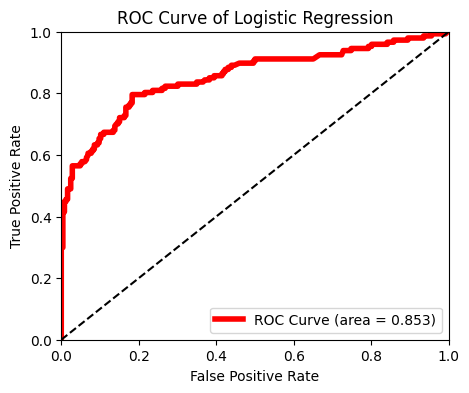

In [186]:
# 테스트 데이터셋에 대한 정확도, 정밀도, 재현도, f1 score 출력
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.3f' % precision_score(y_test, y_pred))
print('recall: %.3f' % recall_score(y_test, y_pred))
print('f1: %.3f' % f1_score(y_test, y_pred))

# AUC 출력
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
auc_score = roc_auc_score(y_test, y_pred_probability)
print('AUC: %.3f' % auc_score)

# ROC Curve 그래프 출력
plt.figure(figsize=(5,4))
plt.plot(false_positive_rate, true_positive_rate,
         label='ROC Curve (area = %.3f)' % auc_score,
         color='red',
         linewidth=4.0)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.legend(loc='lower right')
plt.show()

피처 엔지니어링 전 로지스틱 회귀 모델 평가 결과 비교   
- accuracy: 0.80 -> 0.80
- precision: 0.756 -> 0.739
- recall: 0.67 -> 0.714
- F1: 0.71 -> 0.727
- AUC: 0.838 -> 0.853

평가 점수를 비교해본 결과   
정확도는 차이가 없고,
정밀도, 재현율은 피처 엔지니어링 전이 더 높다.  
하지만 F1과 AUC score는 피처 엔지니어링 후 더 높아졌다. 

다음은 분류 모델에서 피처들의 영향력을 그래프로 살펴보자.  

**피처 영향력 그래프 (회귀 분석 계수)**

<Figure size 500x400 with 0 Axes>

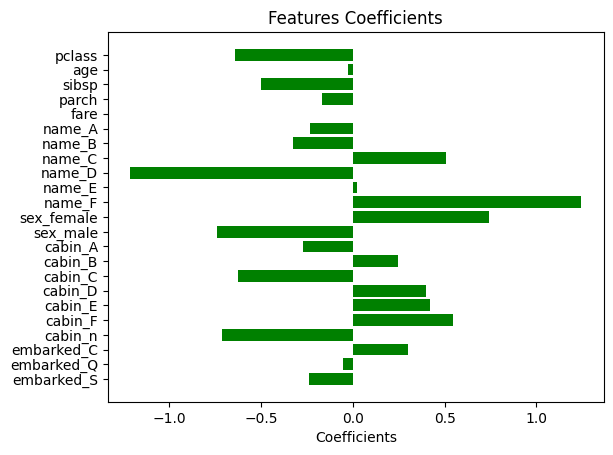

In [198]:
# 예측 대상인 survived 피처를 제외한 모든 피처명을 리스트로 반환 (그래프의 y 축)
cols = df_train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 피처별 회귀 분석 계수를 그래프의 x 축으로 하여 피처 영향력 그래프를 출력
plt.figure(figsize=(5,4))
fig, ax = plt.subplots() # 전체, 낱개
ax.barh(y_pos, lr.coef_[0], align='center', color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coefficients')
ax.set_title('Features Coefficients')

plt.show()

In [240]:
# {피쳐: 회귀 계수} 딕셔너리 생성
coef_dict = {
    feature: coef for feature, coef in zip(cols, lr.coef_[0])
}

# 분류에 영향력이 큰 피처 상위 5개 
coef_top5 = sorted(coef_dict.items(), key=lambda x: x[1], reverse=True)[:5]
coef_top5

[('name_F', 1.245067826545517),
 ('sex_female', 0.7405626086533652),
 ('cabin_F', 0.5465546844974022),
 ('name_C', 0.5097336469946795),
 ('cabin_E', 0.42108007707937994)]

피처 영향력 그래프와 회귀 계수가 큰 피처 상위 5개를 살펴보았을 때,  
피처 엔지니어링으로 생성된 'name'과 'cabin'이 모델 분석에 중요한 영향을 끼쳤다는 것을 알 수 있다.  

### 1.4 평가: 모델 검증하기

다음의 두 가지 방법을 통해 모델의 **과적합 여부**를 검증해보자.  
1. K-fold 교차 검증 (K-fold cross validation)
2. 학습 곡선 (Learning Curve)

**K-fold 교차 검증**  
train과 test 데이터 셋을 나눌 때, 두 데이터는 불균등하게 나눠졌을 가능성이 있다.  
K-fold 교차 검증은 이 가능성을 낮춰주는 방법으로, 데이터를 k개의 fold로 나누어 k-1개는 train 데이터, 나머지 한 개는 test 데이터로 사용한다.  

예시) K: 5   
Iteration 1 (**Test** | Train | Train | Train | Train)  
Iteration 2 (Train | **Test** | Train | Train | Train)  
Iteration 3 (Train | Train | **Test** | Train | Train)  
Iteration 4 (Train | Train | Train | **Test** | Train)  
Iteration 5 (Train | Train | Train | Train | **Test**)  

예시에서는 총 5회의 학습(Iteration)을 통해 모델의 분할 검증(Test)을 5회 반복하는 것이다.  
만약 이 K번의 검증 과정에서 테스트 점수 간의 차이가 크지 않다면 모델은 과적합이 일어났을 가능성이 낮은 것이다.  

**K-fole 교차 검증**

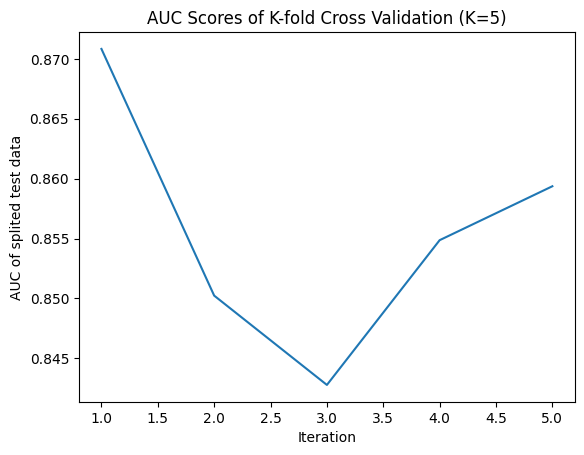

In [249]:
from sklearn.model_selection import KFold
# k=5로 설정
k =5
cv = KFold(k, shuffle=True, random_state=42)
auc_history = []

# k-fold를 5번의 분할 학습으로 반복
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)): # enumerate(): 인덱스와 원소로 이루어진 튜플(tuple) 생성
        
        # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터셋으로 지정한다. 매 반복시마다 테스트 데이터셋은 변경된다.
        df_train = whole_df_encoded.iloc[train_data_row]
        df_test = whole_df_encoded.iloc[test_data_row]
        
        # survived 피처를 y, 나머지 피처들을 x 데이터로 지정
        splited_x_train = df_train.drop(['survived'], axis=1).values
        splited_y_train = df_train['survived'].values
        splited_x_test = df_test.drop(['survived'], axis=1).values
        splited_y_test = df_test['survived'].values
        
        # 주어진 데이터로 로지스틱 회귀 모델을 학습
        lr = LogisticRegression(max_iter=800, random_state=42)
        lr.fit(splited_x_train, splited_y_train)
        y_pred = lr.predict(splited_x_test)
        y_pred_probability = lr.predict_proba(splited_x_test)[:,1]
        
        # 테스트 데이터셋의 AUC를 계산하여 auc_history에 저장
        false_positive_rate, true_positive_rate, threshold = roc_curve(splited_y_test, y_pred_probability)
        auc_score = roc_auc_score(splited_y_test, y_pred_probability)
        auc_history.append(auc_score)

# auc_history에 저장된 다섯 번의 학습 결과(AUC)를 그래프로 출력
plt.xlabel('Iteration')
plt.ylabel('AUC of splited test data')
plt.plot(range(1, k+1), auc_history) # baseline # plt.plot(x,y)
plt.title('AUC Scores of K-fold Cross Validation (K=5)')
plt.show()

그래프를 살펴본 결과, AUC가 큰 폭으로 변화하고 있는 것을 볼 수 있다.  
따라서 이 모델은 다소 불안정한 모델이라고 할 수 있다.  
다만 이러한 결과는 데이터의 개수가 적기 때문에 발생하는 현상이다.   
게다가 모든 실행에서 공통적으로 Test AUC가 0.8 이상의 수치를 기록했기 떄문에 이 분류 모델은 '과적합이 발생했지만 대체로 높은 정확도를 가지는 모델'이라고 할 수 있다.  

**학습 곡선**

학습 데이터와 테스트 데이터의 점수가 벌어지는 과적합 상황은 학습 곡선을 관찰함으로써 더 쉽게 살펴볼 수 있다.  
학습 데이터 샘플의 개수가 증가함에 따라 학습과 테스트 두 점수가 어떻게 변화하는지를 관찰해보자.  

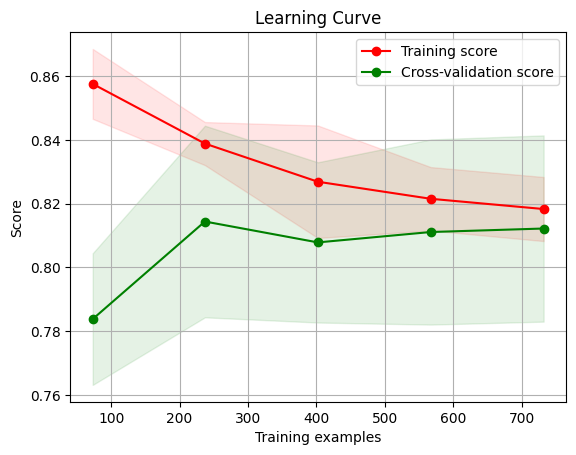

In [251]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()

이를 통해 데이터가 300개 이상인 경우에는 과적합의 위험이 낮아진다는 것을 알 수 있다.  

### 정리

- **로지스틱 회귀 분류 모델**  
    - 모델의 결과인 0~1 사이의 확률 값을 0 또는 1로 분류하는 방법이다.  
    - 피처 영향력을 분석하기 용이하다는 장점이 있다.  
- **결측값 처리**  
    - 결측값을 처리하는 방법은 결측값을 삭제하는 방법 또는 임의의 수치로 채워 넣는 방법이 있다.
- **분류 모델의 평가**  
    - Confusion Matrix를 기반으로 한 분류 모델의 평가지표
        - Confusion Matrix를 통해 계산된 Accuracy, Precision, Recall, F1-score, AUC 등의 수치로 분류 모델을 평가한다.  
- **분류 모델의 개선**  
    - 피처 엔지니어링: 모델에 사용할 피처를 가공하는 분석 작업
- **분류 모델의 검증**  
    - 모델의 성능을 검증하기 위해서는 모델의 과적합 여부를 판단한다.  
    - 그 방법으로 K-fold 교차 검증, 학습 곡선의 관찰 등의 방법이 있다.  

## 2. 강남역 맛집 리뷰로 알아보는 감성 분류

분류 모델의 대표적인 활용 방법 중 하나는 **감성 분류**이다.  
감성 분류란 문서를 긍정(positive) 또는 부정(negative) 의견으로 나누어 분류하는 것이다.  

강남역 맛집 리뷰 데이터에 대해 감성 분류를 수행하고 맛집을 식별해주는 중요 키워드를 함께 알아보자.  

### 2.1 크롤링: 카카오맵 리뷰 크롤링

먼저 크롤링을 이용하여 감성 분류에 필요한 데이터를 직접 수집해보자.  
크롤링할 데이터는 카카오맵의 음식점 랭킹 정보이다.  

이전의 나무위키 크롤링과 마찬가지로, 이번 예제에서도 selenium을 이용한 크롤링을 수행한다.  
카카오 맵 페이지의 경우, Javascript 기반으로 페이지의 정보가 동적 로딩되기 때문에,  
나무위키 페이지보다 크롤링하기에 조금 더 까다로운 편이다.  

우선 페이지의 구성을 보면, 검색어를 입력하면 그에 맞는 음식점이 결과로 나오는 형태이다.  
필요한 정보는 각 음식점의 리뷰 데이터이기 때문에, 음식점마다 달려있는 '상세보기' 링크를 통해 리뷰 데이터를 수집해야 한다.  
이를 얻기 위해 상세보기 링크를 추출하는 과정이 필요하다.  
아래는 '강남역 고기집'을 검색했을 때 나오는 음식점들의 상세보기 링크를 크롤링한 것이다.  

**카카오맵 검색 결과로 나오는 고기집의 '상세보기' 페이지 url 정보 구하기**

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import re
import time

# brew로 설치된 chromdriver의 path
path = '/usr/local/chromedriver'

# 크롤링할 사이트 주소 정의
source_url = "https://map.kakao.com/"

# 크롬 드라이버 사용
driver = webdriver.Chrome(path)

# 카카오 지도에 접속
driver.get(source_url)

# 검색창에 검색어를 입력
searchbox = driver.find_element(By.XPATH, "//input[@id='search.keyword.query']")
searchbox.send_keys("강남역 고기집")

# 검색버튼을 놀러서 결과를 가져옵니다
searchbutton = driver.find_element(By.XPATH, "//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click()", searchbutton)

# 검색 결과를 가져올 시간 대기
time.sleep(2)

# 검색 결과의 페이지 소스
html = driver.page_source

# BeautifulSoup을 이용하여 html 정보 파싱
soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

# a 태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성
page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용한 브라우저 종료
driver.close()

/var/folders/hf/v7h_0c452jq2_96439gvcks40000gn/T/ipykernel_80572/4110363268.py:19: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(path)


https://place.map.kakao.com/95713992
https://place.map.kakao.com/2011092566
https://place.map.kakao.com/1503746075
https://place.map.kakao.com/741391811
https://place.map.kakao.com/1052874675
https://place.map.kakao.com/168079537
https://place.map.kakao.com/1648266796
https://place.map.kakao.com/27238067
https://place.map.kakao.com/26573718
https://place.map.kakao.com/263830255
https://place.map.kakao.com/1511737742
https://place.map.kakao.com/1780387311
https://place.map.kakao.com/27511865
https://place.map.kakao.com/56929632
https://place.map.kakao.com/785573131


**가져온 식당별 '상세보기' 페이지의 평점과 리뷰 데이터 크롤링**

In [406]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

driver = webdriver.Chrome(path)

for page_url in page_urls:
    
    # '상세보기' 페이지에 접속
    driver.get(page_url)
    time.sleep(2) 
    
    # 리뷰 크롤링
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 리뷰를 제공하지 않는 경우, 다음 항목으로 넘어가기
    try:  
        contents_div = soup.find(name='ul', attrs={'class':'list_evaluation'})
        
        # '후기 더보기'를 다섯 번 클릭
        for more_reviews in range(1, 6): 
            
            # 오류가 나는 경우, 다음 항목으로 넘어가기
            try: 
                another_reviews = driver.find_element(By.XPATH, "//span[@class='txt_more']")
                another_reviews.click()
                time.sleep(2) 
                
                # 평점과 코멘트 가져오기
                rates = contents_div.find_all(name='span', attrs={'class':'ico_star inner_star'})
                reviews = contents_div.find_all(name='p', attrs={'class':'txt_comment'})

                for rate, review in zip(rates, reviews):
                    
                    rate = int(int(str(rate)[-13:-11]) / 20)
                    review = review.find(name='span').text
                    row = [rate, review]
                    df_new = pd.DataFrame([row], columns=columns)
                    df = pd.concat([df, df_new], axis=0, ignore_index=True) 
                    
            except:
                pass       
    except:
        pass
            
driver.close()

/var/folders/hf/v7h_0c452jq2_96439gvcks40000gn/T/ipykernel_80572/3356576542.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(path)


크롤링된 데이터에서 4점 이상의 리뷰를 긍정(1), 3점 이하를 부정(0) 리뷰라고 평가하자.    

In [407]:
df['y'] = df['score'].apply(lambda x: 1 if x > 3 else 0 )

print(df.shape)
df.tail()

(180, 3)


,score,review,y
175,0,고기 질이 좋았어요네이버로 예약하고가면 직원분께서 직접 구워주시는데 너무 잘 구워주...,0
176,0,,0
177,0,존맛탱,0
178,0,고기 질이 좋았어요네이버로 예약하고가면 직원분께서 직접 구워주시는데 너무 잘 구워주...,0
179,0,,0


### 2.2 텍스트 전처리: 분류 모델 피처로 변환하기

다음 단계는 수집한 텍스트 데이터를 감성 분류의 피처로 사용할 수 있도록 하는 텍스트 전처리 과정이다.  

먼저 데이터에서 한글 문자열을 필터링해보자.  

**한글 텍스트 전처리**

In [415]:
import re

# 텍스트 정제 함수: 한글 이외의 문자는 전부 제거 
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

# 함수를 적용하여 리뷰에서 한글만 추출
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
df.drop(['review'], axis=1, inplace=True)

# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출
df = df[df['ko_text'].str.len() > 0]

print(df.shape)
df.head()

(155, 3)


,score,y,ko_text
0,3,0,맛은 그냥 보통임 가운데에 치즈가 있어서 보기에는 괜춘함
1,1,0,일 방문 저녁 시쯤 방문하여 밥먹는데 벽에서 쥐나와서 활보함 쥐나왔는데 직원들은 별...
2,1,0,직원분이 너무 불친절하세요불키라는 말도 안해주고 계속 명령조로 얘기하십니다ㅎㅎ
3,3,0,맛은 그냥 보통임 가운데에 치즈가 있어서 보기에는 괜춘함
4,1,0,일 방문 저녁 시쯤 방문하여 밥먹는데 벽에서 쥐나와서 활보함 쥐나왔는데 직원들은 별...


**형태소 추출**

In [418]:
from konlpy.tag import Okt

# knolpy 라이브러리로 텍스트 데이터에서 형태소를 추출하는 함수 생성
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작 테스트
result = get_pos(df['ko_text'].values[0])
print(result)

['맛/Noun', '은/Josa', '그냥/Noun', '보통/Noun', '임/Noun', '가운데/Noun', '에/Josa', '치즈/Noun', '가/Josa', '있어서/Adjective', '보기/Noun', '에는/Josa', '괜춘함/Noun']


마지막으로 텍스트 데이터를 분류 모델에 학습이 가능한(=연산 가능한) 데이터셋으로 만들어보자.  

방법은 다음과 같다. 
1. 텍스트 데이터셋으로부터 말뭉치(corpus)를 생성한다.  
   ex) '너무 맛있었습니다.' -> '너무' '맛'
2. 서로 다른 n개의 형태소는 각 텍스트 데이터의 벡터 길이가 된다.  
   만약 텍스트에 해당 단어가 존재하면 벡터의 값을 1로, 존재하지 않으면 벡터의 값을 0으로 할당한다.  
   ex) 말뭉치에 만약 3개의 형태소가 있다고 가정하자. ('너무', '맛', '친절')  
       이는 학습 데이터셋에서 벡터의 형태로 표현한다.  ['너무'|'맛'|'친절']   
       따라서 '너무 친절했습니다'의 경우 학습 데이터셋에서는 [101] 이 된다.  

**분류 모델의 학습 데이터로 변환하기: courpus index 생성**

In [419]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)로 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x)) # tokenizer: 텍스트 데이터의 전처리 방식을 입력
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

print(X.shape)

/Users/hyegwan/opt/anaconda3/envs/pybook/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(155, 644)


학습 데이터셋과 말뭉치가 올바르게 생성되었는지를 직접 확인해보자.  


In [424]:
print(str(index_vectorizer.vocabulary_)[:100]+'..')

{'맛/Noun': 220, '은/Josa': 460, '그냥/Noun': 74, '보통/Noun': 299, '임/Noun': 489, '가운데/Noun': 14, '에/Josa..


만약 '맛'이라는 형태소를 포함한 텍스트라면 220번 피처의 벡터값은 1이 되는 것이다.  

다음 실행 결과는 원래의 텍스트 데이터와 변환 이후의 데이터를 함께 출력한 것이다.  

In [425]:
print(df['ko_text'][0])
print(X[0]) # 1이 있는 (x, y) 좌표. x가 1열밖에 없어서 y값이 곧 고유 인덱스 번호가 된다. 

맛은 그냥 보통임 가운데에 치즈가 있어서 보기에는 괜춘함
  (0, 220)	1
  (0, 460)	1
  (0, 74)	1
  (0, 299)	1
  (0, 489)	1
  (0, 14)	1
  (0, 428)	1
  (0, 572)	1
  (0, 5)	1
  (0, 496)	1
  (0, 291)	1
  (0, 429)	1
  (0, 56)	1


변환된 학습 데이터 셋에서는 220, 460, 74, ..., 56번 위치의 X 피처가 1로 채워진 데이터가 된다.  

하지만 텍스트 데이터에 **중복되는 형태소가 존재**한다면 어떻게 될까?  
만약 '너무 좋았습니다', '너무 너무 너무 좋았습니다'라는 두 텍스트 데이터가 있다면  
중복되는 형태소 '너무'가 존재하기 때문에 이 둘은 같은 데이터로 변환된다.  

이 문제를 해결하기 위해 텍스트를 피처로 만드는 다른 방법인 **TF-IDF(Term Frequency - Inverse Document Frequency)** 를 적용해보자.  
TF-IDF는 단어의 빈도를 나타내는 **TF**와 문서 빈도를 나타내는 DF의 역수(Inverse)인 **IDF를 곱한 값**을 의미한다.  

ex) 1번 텍스트에 '맛집'이라는 단어가 3번 등장하고, 모든 데이터에서는 '맛집'이라는 단어가 10개의 텍스트에 등장한다고 할 때,  
1번 문서에서 '맛집'의 TF=3, IDF=0.1이 된다.   

따라서 TF-IDF는 **다른 문서들에서는 등장하지 않았지만 현재 문서에서는 많이 등장하는 단어**를 의미하며   
**그 단어가 현재 문서에서 얼마나 중요한지를 피처로 나타낼 수 있는 방법**이다.  

**분류 모델의 학습 데이터로 변환하기: TF-IDF로 변환**

In [427]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

print(X.shape)
print(X[0])

(155, 644)
  (0, 572)	0.3399591518921128
  (0, 496)	0.2915663050242128
  (0, 489)	0.2915663050242128
  (0, 460)	0.16909992607633365
  (0, 429)	0.2616514202501773
  (0, 428)	0.17733797918901945
  (0, 299)	0.3399591518921128
  (0, 291)	0.3399591518921128
  (0, 220)	0.18652491786293843
  (0, 74)	0.2616514202501773
  (0, 56)	0.3399591518921128
  (0, 14)	0.3399591518921128
  (0, 5)	0.14268508853247377


'맛은 그냥 보통임 가운데에 치즈가 있어서 보기에는 괜춘함'라는 텍스트 데이터가 TF-IDF 피처로 표현된 것을 확인할 수 있다.  

### 2.3 분류: 긍정/부정 리뷰 분류하기

이제 감성 분류를 위한 데이터셋이 모두 준비 되었다.  
이 데이터를 이용하여 분류 모델을 학습시켜보자.  

가장 먼저 학습 데이터셋과 테스트 데이터셋으로 데이터를 분리한다.  

**데이터셋 분리**

In [464]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(x_train.shape)
print(x_test.shape)

(116, 644)
(39, 644)


**분류 모델링: 로지스틱 회귀 모델 학습 및 평가**

In [465]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀 모델 학습
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1] # 1일 확률

# 로지스틱 회귀 모델 성능 평가
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred)) # 정확도
print('Precision: %.3f' % precision_score(y_test, y_pred)) # 정밀도
print('Recall: %.3f' % recall_score(y_test, y_pred)) # 재현도
print('F1: %.3f' % f1_score(y_test, y_pred))

Accuracy: 0.90
Precision: 1.000
Recall: 0.333
F1: 0.500


AUC : 1.000


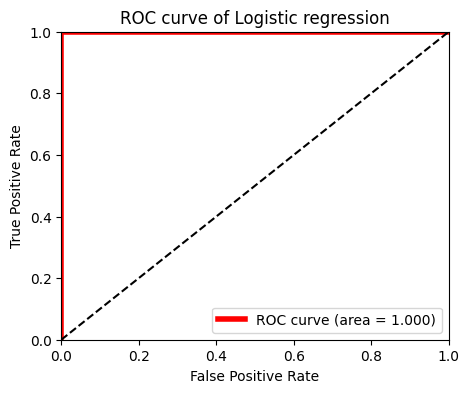

In [467]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC 계산
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
auc_score = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % auc_score)

# ROC curve 그래프 출력
plt.figure(figsize=(5,4))
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

성능 평가 결과, 대부분의 평가 수치가 매우 높은 것을 볼 수 있다.  

이렇게 분류기의 성능이 비정상적으로 높은 경우에는 모델의 평가 방법이나 과정을 의심해볼 필요가 있다.  

이러한 의심을 확인하기 위해 Confusion Matrix를 출력해보자.  

**Confusion Matrix**

In [431]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix 출력
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[31  0]
 [ 4  4]]


대부분을 positive(1)로 예측하는 것을 알 수 있다.  
이렇게 모델이 하나의 결과만을 예측하도록 잘못된 학습을 하는 경우를 **클래스의 불균형 문제**라고 한다.  

In [432]:
# y가 0과 1을 각각 얼마나 가지고 있는지를 출력
df['y'].value_counts()

0    130
1     25
Name: y, dtype: int64

Negative와 Positive의 비율이 약 5:1인 것을 확인할 수 있다.  

클래스 불균형 문제를 해결하기 위해 두 클래스 간의 비율을 동일하게 맞춰보자.  
클래스를 1:1 비율로 샘플링 하기 위해 y가 1인 20개의 샘플, y가 0인 20개의 샘플을 임의로 추출한다.  
그리고 이 데이터를 다시 학습데이터 셋 (30개)와 테스트 데이터셋(10개)으로 분리하는 방법을 사용한다.  

**클래스 불균형 문제 해결하기: 1:1 비율의 랜덤 샘플링**

In [459]:
# 1:1 비율로 랜덤 샘플링 수행
df = df.reset_index()
positive_random_idx = df[df['y']==1].sample(20, random_state=42).index.tolist()
negative_random_idx = df[df['y']==0].sample(20, random_state=42).index.tolist()

# 랜덤 데이터를 학습과 테스트 데이터셋으로 나누기
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]

x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.25, shuffle=True)

print(x_train.shape)
print(x_test.shape)

(30, 644)
(10, 644)


균형을 맞춰 샘플링한 데이터로 학습과 평가를 진행한다.

**로지스틱 회귀 모델 재학습 및 재평가**

In [460]:
# 로지스틱 회귀 모델 다시 학습
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1]

# 학습한 모델을 테스트 데이터로 평가
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))

Accuracy: 1.00
Precision: 1.000
Recall: 1.000
F1: 1.000


실행 결과, 성능이 더 떨어져야하는데......? 데이터 수가 너무 적어서 그런가...?

일단 이전 문제가 잘 해결되었는지 확인하기 위해 다시 confusion matrix를 살펴보자.  

In [461]:
# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[6 0]
 [0 4]]


새롭게 학습한 분류 모델은 0과 1 두 클래스를 비슷한 비율로 예측하고 있는 것을 알 수 있다.  

이처럼 **분류 모델의 평가 척도는 데이터셋의 샘플링 방법에 따라 성능과 기준이 달라질 수 있다.**  

### 2.4 분석: 중요 키워드 분석하기

지금까지 학습한 감성 분류 모델에서는 어떤 형태소가 높은 영향력을 가지고 있을까?  
이를 알아보기 위해 로지스틱 회귀 모델의 피처 영향력을 추출해보자. 

다음 그래프에서 양수인 피처들은 긍정적이라고 판단되는 형태소이며, 음수인 피처들은 부정적으로 판단되는 형태소이다.  

**회귀 모델의 피처 영향력**

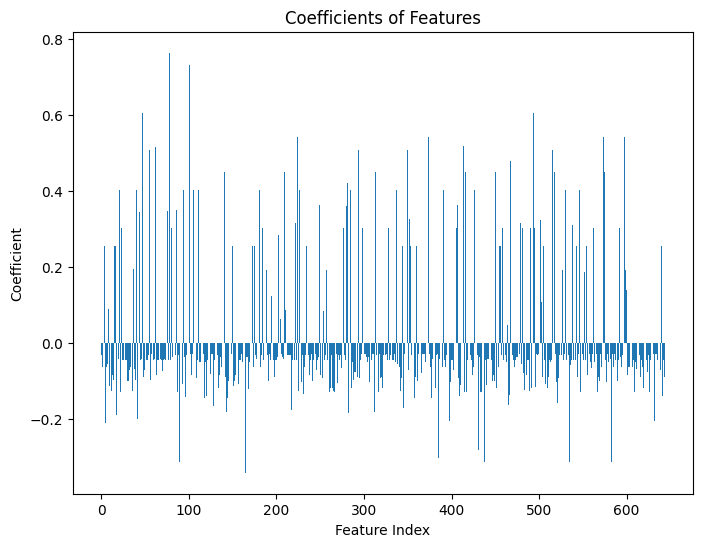

In [485]:
# 학습한 회귀 모델의 계수 출력
plt.figure(figsize=(8,6))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])
plt.xlabel('Feature Index')
plt.ylabel('Coefficient')
plt.title('Coefficients of Features')
plt.show()

In [491]:
# 앞에서 5개 (양수) 긍정적인 피처
print('Positive \n', sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5]) 

# 뒤에서 5개 (음수) 부정적인 피처
print('Negative \n', sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:]) 

Positive 
 [(0.7643379179938744, 78), (0.7332750855452875, 101), (0.6774125874138912, 3), (0.6467487932721763, 588), (0.60618188576975, 494)]
Negative 
 [(-0.31261004777800766, 583), (-0.31261004777800766, 535), (-0.31261004777800766, 438), (-0.31261004777800766, 89), (-0.34066887455909717, 165)]


**중요 변수의 형태소**  

In [492]:
# 회귀 모델의 계수를 높은 순으로 (= 긍정적인 피처 순으로) 정렬
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

정렬된 계수를 -  *(계수, 인덱스)*    
index_vectorizer 객체에 -  *{형태소: 인덱스}*  
다시 맵핑하여  
어떤 형태소인지를 출력한다. -  *(형태소, 계수)*

In [513]:
# 'key=인덱스: value=형태소'인 딕셔너리 생성 
# (index_vectorizer.vocabulary_는 앞에서 CountVectorizer로 만든 말뭉치 dict{형태소: 인덱스}이다.)
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

print(str(invert_index_vectorizer)[:100]+'..')

{220: '맛/Noun', 460: '은/Josa', 74: '그냥/Noun', 299: '보통/Noun', 489: '임/Noun', 14: '가운데/Noun', 428: '에..


**상위 20개 긍정 형태소**

In [514]:
for coef in coef_pos_index[:20]: 
    print(invert_index_vectorizer[coef[1]], coef[0])
    # coef[0]: 계수, coef[1]: 인덱스
    # invert_index_vectorizer[coef[1]]: 상위 n개 인덱스에 해당하는 형태소 

그램/Noun 0.7643379179938744
나/Josa 0.7332750855452875
ㅎㅎ/KoreanParticle 0.6774125874138912
특색/Noun 0.6467487932721763
있는/Adjective 0.60618188576975
수/Noun 0.60618188576975
고깃집/Noun 0.60618188576975
필수/Noun 0.5419282760349746
친절하/Adjective 0.5419282760349746
심/Noun 0.5419282760349746
맛있네요/Adjective 0.5419282760349746
약간/Noun 0.520137446364018
다/Adverb 0.5164565755007038
구워주셔서/Verb 0.5164565755007038
적당히/Adjective 0.5095586119959162
셋트/Noun 0.5095586119959162
보니/Verb 0.5095586119959162
괜찮음/Adjective 0.5095586119959162
이니/Josa 0.4784579742725242
룸/Noun 0.47322154558581975


더 나아가, '/'로 구분되어 있는 품사를 활용하여 품사별 형태소를 추출할 수 있다.  

피처 영향력에 따라 정렬된 형태소에서 품사별(명사, 형용사) 긍정,부정 형태소를 10개씩 살펴보자.  

**상위 10개 명사/형용사 형태소**

In [531]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의  긍정적인 형태소 추출
for coef in coef_pos_index:
    pos_category = invert_index_vectorizer[coef[1]].split('/')[1] # 품사 = '/'를 기준으로 나눈 후 두 번째 것
    if pos_category == 'Noun':
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    
    elif pos_category == 'Adjective':
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [532]:
# 상위 10개의 명사 출력
noun_list[:10]

[('그램/Noun', 0.7643379179938744),
 ('특색/Noun', 0.6467487932721763),
 ('수/Noun', 0.60618188576975),
 ('고깃집/Noun', 0.60618188576975),
 ('필수/Noun', 0.5419282760349746),
 ('심/Noun', 0.5419282760349746),
 ('약간/Noun', 0.520137446364018),
 ('셋트/Noun', 0.5095586119959162),
 ('룸/Noun', 0.47322154558581975),
 ('요/Noun', 0.4510022683652991)]

In [533]:
# 상위 10개의 형용사 출력
adjective_list[:10]

[('있는/Adjective', 0.60618188576975),
 ('친절하/Adjective', 0.5419282760349746),
 ('맛있네요/Adjective', 0.5419282760349746),
 ('적당히/Adjective', 0.5095586119959162),
 ('괜찮음/Adjective', 0.5095586119959162),
 ('친절하세요/Adjective', 0.4510022683652991),
 ('있진/Adjective', 0.4510022683652991),
 ('없어도/Adjective', 0.4039784749167168),
 ('아늑해서/Adjective', 0.4039784749167168),
 ('맛있어요/Adjective', 0.4039784749167168)]

품사별 형태소를 살펴본 결과,  

명사에서는 '그램'(g), '특색', '고깃집', '필수','셋트' 등 이 긍정적인 키워드로 나타났고  

형용사에서는 '친절하'/'친절하세요', '맛있네요'/'맛있어요, '적당히', '괜찮음', '아늑해서' 등 이 긍정적인 키워드로 나타났다.  

긍정적인 키워드를 어느정도 잘 추려낸 것으로 보인다.  

### 정리

- **감성 분류의 피처**
    - 텍스트를 분류 모델의 피처로 만드는 방법으로 '말뭉치' 개념을 사용한다.  
      말뭉치에 등장한 형태소 셋(set) 만큼을 벡터의 길이로 한 뒤, 형태소 위치에 해당하는 피처의 값을 1로 지정한다.  
- **TF-IDF**
    - 단어의 중요도를 파악하는 TF-IDF는 현재 문서에서의 빈도(TF)와 전체 문서에서의 빈도(DF)를 이용 중요도를 파악하고 이를 피처로 사용한다. 
- **클래스 불균형**
    - 분류 모델에서는 Positive sample, Negative sample의 비율 때문에 클래스 불균형 문제가 발생할 수 있다.  
- **감성 키워드 분석**
    - 로지스틱 회귀 모델에서의 변수 중요도(피처 영향력)를 활용하여 형태소의 감성 영향력을 분석할 수 있다. 